In [21]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import GCCA, shuffle_block, data_superbowl, corr_component, avg_corr_coe
from sklearn.covariance import LedoitWolf
from numpy import linalg as LA
from scipy import signal
from tqdm import tqdm

In [22]:
# data = scipy.io.loadmat('../Correlated Component Analysis/data/Prepro_EEG.mat')
# X_prepro = data['X']
# fs = 256
# T, D, N = X_prepro.shape

In [23]:
head = '../Correlated Component Analysis/data'
datatype = 'preprocessed'
year = '2013'
view = 'Y2'
X_prepro, fs = data_superbowl(head=head, datatype=datatype, year=year, view=view)
T, D, N = X_prepro.shape

In [24]:
n_components = 500
lam, W = GCCA(X_prepro, n_components=n_components, regularization='lwcov')

In [25]:
corr_coe = (1/lam-1)/(N-1)

In [26]:
# corr_coe = avg_corr_coe(X_prepro, W, N, n_components=n_components)
# corr_coe

### Permutation Test

In [27]:
num_test = 1000
lam_topK = np.empty((0, n_components))
corr_topK = np.empty((0, n_components))
for i in tqdm(range(num_test)):
    X_shuffled = shuffle_block(X_prepro, t=3, fs=fs)
    lam_permu, W_permu = GCCA(X_shuffled, n_components=n_components, regularization='lwcov')
    # corr_permu = avg_corr_coe(X_shuffled, W_permu, N, n_components=n_components)
    corr_permu = (1/lam_permu-1)/(N-1)
    lam_topK = np.concatenate((lam_topK, np.expand_dims(lam_permu, axis=0)), axis=0)
    corr_topK = np.concatenate((corr_topK, np.expand_dims(corr_permu, axis=0)), axis=0)

100%|██████████| 1000/1000 [52:24<00:00,  3.14s/it]


Component 117, top 0.5%


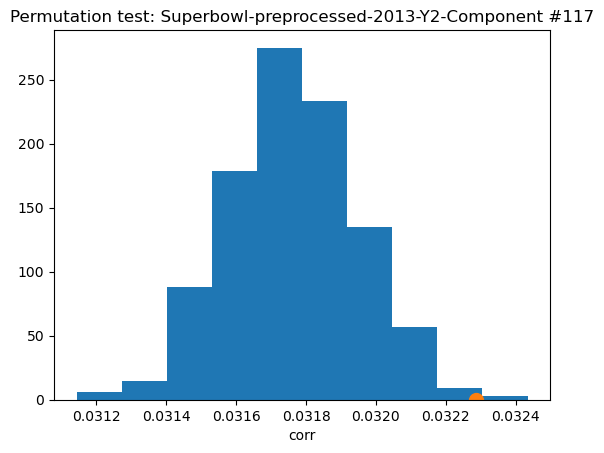

In [38]:
compo = 117
signifi = sum(corr_topK[:,compo-1]>corr_coe[compo-1])/num_test*100
print("Component {compo}, top {signifi}%".format(compo=compo, signifi=signifi))
plt.hist(corr_topK[:,compo-1])
# plt.title('Permutation test: Example-'+'Component #'+str(compo))
plt.title('Permutation test: Superbowl-'+datatype+'-'+year+'-'+view+'-'+'Component #'+str(compo))
plt.xlabel('corr')
plt.plot(corr_coe[compo-1], 0, marker="o", markersize=10)

### Cross-validation

In [12]:
fold = 10
cv_n_components = 5
corr_train = np.zeros((fold, cv_n_components))
corr_test = np.zeros_like(corr_train)
T, D, N = X_prepro.shape
for i in range(fold):
    len_test = T // fold
    X_test = X_prepro[len_test*i:len_test*(i+1),:,:]
    X_train = np.delete(X_prepro, range(len_test*i, len_test*(i+1)), axis=0)
    _, W_train = GCCA(X_train, n_components=n_components, regularization='lwcov')
    corr_train[i,:] = avg_corr_coe(X_train, W_train, N, n_components=cv_n_components)
    corr_test[i,:] = avg_corr_coe(X_test, W_train, N, n_components=cv_n_components)

In [13]:
corr_train

array([[0.18695489, 0.10346385, 0.09422231, 0.08864449, 0.09141321],
       [0.1851154 , 0.10362256, 0.09067646, 0.09287107, 0.09179427],
       [0.18410406, 0.10447832, 0.09050854, 0.09037347, 0.0905371 ],
       [0.18077828, 0.10381551, 0.09348267, 0.08891155, 0.09006738],
       [0.18450125, 0.10529833, 0.09307745, 0.09335208, 0.08854061],
       [0.19210734, 0.1063723 , 0.09384483, 0.09537296, 0.09069704],
       [0.18259315, 0.10118016, 0.09390773, 0.08989479, 0.09089701],
       [0.17944332, 0.10455837, 0.09370343, 0.09162434, 0.09251473],
       [0.18315697, 0.1034634 , 0.09317377, 0.09076334, 0.08997045],
       [0.17669433, 0.1035339 , 0.09054995, 0.09298246, 0.09066753]])

In [14]:
corr_test

array([[ 0.06657801,  0.02475763, -0.00545771, -0.00869653, -0.00163309],
       [ 0.11698515,  0.03618207, -0.00854722,  0.00124039,  0.00112029],
       [ 0.11440477,  0.02714504, -0.00156294,  0.01778563,  0.0019629 ],
       [ 0.12333297,  0.02958446, -0.00309646, -0.00173378,  0.00393862],
       [ 0.11625583,  0.03339597,  0.00640627,  0.01806306,  0.009238  ],
       [ 0.04735798,  0.01947088, -0.00486847, -0.00415218,  0.00576268],
       [ 0.13568456,  0.04858228,  0.00526712,  0.00216246, -0.00343683],
       [ 0.15983284,  0.02232777, -0.00192774,  0.00160669, -0.00389223],
       [ 0.12707559,  0.03912399,  0.00652858,  0.00602037, -0.0043251 ],
       [ 0.16100651,  0.03001   , -0.00390323,  0.01458816,  0.00988173]])

In [15]:
np.mean(corr_train, axis=0)

array([0.1835449 , 0.10397867, 0.09271471, 0.09147905, 0.09070993])

In [16]:
np.mean(corr_test, axis=0)

array([ 0.11685142,  0.03105801, -0.00111618,  0.00468843,  0.0018617 ])

### GCCA vs Correlated Component Analysis

In [17]:
ISC, W = corr_component(X_prepro, n_components=n_components)

In [18]:
ISC

array([ 1.14711853e-01,  3.95960253e-02,  2.80535031e-02,  2.19923801e-02,
        2.02055599e-02,  1.80586546e-02,  1.75645867e-02,  1.60299057e-02,
        1.51666048e-02,  1.43252407e-02,  1.32350412e-02,  1.30911141e-02,
        1.22575251e-02,  1.10148251e-02,  1.04279885e-02,  1.01627384e-02,
        9.49318003e-03,  8.88227939e-03,  8.52404804e-03,  7.37559348e-03,
        6.90789727e-03,  6.52268378e-03,  6.05219538e-03,  5.66241568e-03,
        4.67972568e-03,  4.38660970e-03,  3.80737061e-03,  3.21632010e-03,
        2.89533766e-03,  1.80276828e-03,  1.48039103e-03,  9.43572356e-04,
        6.39312541e-04, -1.89350238e-05, -1.58365962e-04, -3.36794594e-04,
       -1.92423148e-03, -2.52562108e-03, -2.80158384e-03, -3.41001646e-03,
       -3.59937924e-03, -4.23220042e-03, -4.53520523e-03, -5.54685576e-03,
       -5.85654366e-03, -6.09101887e-03, -6.47485085e-03, -7.66839153e-03,
       -8.35312656e-03, -8.77477800e-03, -9.27489110e-03, -9.85970742e-03,
       -1.11195843e-02, -

In [19]:
# avg_corr_coe(X_prepro, W, N, n_components=n_components)